In [169]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, GPT2TokenizerFast, VisionEncoderDecoderModel, GPT2Tokenizer, GPT2LMHeadModel

In [170]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [165]:
decoder_model = "priyasaravana/languageModelV2_GPT2"
tokenizer_nm = "priyasaravana/tokenizerV2_GPT2"
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_nm)

In [167]:
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
#decoder_model = 'gpt2'
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        encoder_model, decoder_model
    ).to(device)

Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at priyasaravana/languageModelV2_GPT2 and are newly initialized: ['transformer.h.16.crossattention.q_attn.weight', 'transformer.h.19.crossattention.c_proj.weight', 'transformer.h.4.crossattention.c_attn.weight', 'transformer.h.20.crossattention.bias', 'transformer.h.9.crossattention.masked_bias', 'transformer.h.2.crossattention.bias', 'transformer.h.15.crossattention.masked_bias', 'transformer.h.7.ln_cross_attn.weight', 'transformer.h.13.crossattention.c_attn.weight', 'transformer.h.20.crossattention.c_proj.bias', 'transformer.h.15.crossattention.c_proj.weight', 'transformer.h.13.crossattention.bias', 'transformer.h.7.crossattention.masked_bias', 'transformer.h.6.ln_cross_attn.weight', 'transformer.h.2.crossattention.q_attn.weight', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.13.ln_cross_attn.weight', 'transformer.h.14.crossattention.c_proj.bias', 'transformer.h.20.crossattention.c_proj.we

In [ ]:
decoded = tokenizer.decode(15900) 

In [171]:
import urllib.parse as parse
import os

# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False
    
# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)
        
def visualize(model, tokenizer, image_path):
    image = load_image(image_path)
    # preprocess the image
    img = image_processor(image, return_tensors="pt").to(device)
    caption = 'a clock tower with a clock on it\'s side'
    inputs = tokenizer(caption, return_tensors="pt")
    outputs = model.generate(**img)
    model.visualize_attention(image, caption, outputs, layer=1, head=1)
    plt.show()
    
# a function to perform inference
def get_caption(model, image_processor, tokenizer, image_path):
    
    image = load_image(image_path)
    # preprocess the image
    img = image_processor(image, return_tensors="pt").to(device)
    # generate the caption (using greedy decoding by default)
    
    
    output = model.generate(**img)
    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

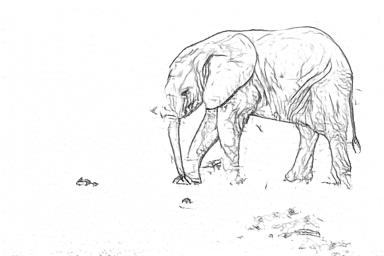

a large elephant standing on top of a sandy area 


In [184]:
# load displayer
device = 'cpu'
from PIL import Image
from IPython.display import display
from IPython.display import display
image_path = r'C:\Users\Asus\Desktop\Images\sketches\100\000000199815.jpg'

display(load_image(image_path))
caption = get_caption(model, image_processor, tokenizer, image_path)
#visualize(model, tokenizer, image_path)
print(caption)

In [72]:
import evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
# load the rouge and bleu metrics

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_metrics(eval_pred):
    preds = eval_pred.predictions 
    labels = eval_pred.label_ids
    # decode the predictions and labels
    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    print("Predictions Caption:", pred_str)
    print("Reference Caption:", labels_str)


    bleu_result_1 = sentence_bleu([pred_str], labels_str, weights=(1, 0, 0, 0))
    bleu_result_2 = sentence_bleu([pred_str], labels_str, weights=(0.5, 0.5, 0, 0))
    bleu_result_3 = sentence_bleu([pred_str], labels_str, weights=(0.33, 0.33, 0.33, 0))
    bleu_result_4 = sentence_bleu([pred_str], labels_str, weights=(0.25, 0.25, 0.25, 0.25))
    meteor_score = nltk.translate.meteor_score.meteor_score([pred_str], labels_str)
    # compute the rouge score
    reference = " ".join(pred_str)
    hypothesis = " ".join(labels_str)
    scores = scorer.score(reference, hypothesis)

    # # Access individual Rouge scores (ROUGE-1, ROUGE-2, ROUGE-L)
    rouge_1_score = scores['rouge1'].fmeasure
    rouge_2_score = scores['rouge2'].fmeasure
    rouge_l_score = scores['rougeL'].fmeasure

    return {
        #**rouge_result, 
        "pred_str":pred_str,
        "labels_str":labels_str,
        "bleu_1": round(bleu_result_1 * 100, 4), 
        "bleu_2": round(bleu_result_2 * 100, 4), 
        "bleu_3": round(bleu_result_3 * 100, 4), 
        "bleu_4": round(bleu_result_4 * 100, 4),
        "meteor": round(meteor_score * 100, 4) ,
        "rouge_1": round(rouge_1_score * 100, 4) ,
        "rouge_2": round(rouge_2_score * 100, 4) ,
        "rouge_l": round(rouge_l_score * 100, 4) 
        # #"gen_len": bleu_result_1["translation_length"] / len(preds)
    }


In [ ]:
tokenizer_nm = "priyasaravana/tokenGPT_1"
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_nm)

In [48]:
from transformers import EvalPrediction

labels = 'A clock on a tower with bells.'

caption_pred = tokenizer([ word for word in caption.split(' ') ], 
                            max_length=20, padding="max_length", truncation=True, return_tensors="pt").to(device)

labels = tokenizer([ word for word in labels.split(' ') ], 
                            max_length=20, padding="max_length", truncation=True, return_tensors="pt").to(device)

eval_prediction = EvalPrediction(predictions=caption_pred["input_ids"], label_ids=labels["input_ids"])
# compute the metrics
metrics = compute_metrics(eval_prediction)
#meteor_score = nltk.translate.meteor_score.meteor_score(caption_pred["input_ids"], labels["input_ids"])
print(f"BLEU_1:   {metrics['bleu_1']:.4f}, BLEU-2: {metrics['bleu_2']:.4f}, BLEU-3: {metrics['bleu_3']:.4f}, BLEU-4: {metrics['bleu_4']:.4f}\n"  +
            f"ROUGE-1:  {metrics['rouge_1']:.4f}, ROUGE-2: {metrics['rouge_2']:.4f}, ROUGE-L: {metrics['rouge_l']:.4f}\n" +
           f"METEOR:   {metrics['meteor']:.4f}")

Predictions Caption: ['a', 'clock', 'tower', 'with', 'a', 'clock', 'on', "it's", 'side', '']
Reference Caption: ['A', 'clock', 'on', 'a', 'tower', 'with', 'bells.']
BLEU_1:   46.5314, BLEU-2: 31.7870, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  70.5882, ROUGE-2: 40.0000, ROUGE-L: 47.0588
METEOR:   52.6919


In [73]:
import requests
import torch
from PIL import Image
from tqdm import tqdm
from datasetsTest import CaptionDatasetTest
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer,GPT2Tokenizer, GPT2TokenizerFast, VisionEncoderDecoderModel, AutoImageProcessor, GPT2LMHeadModel, GPT2Config
data_folder = r'C:\Users\Asus\Documents\Surrey\Research Project\CodeAnalysis\Caption Generation\a-PyTorch-Tutorial-to-Image-Captioning-master\a-PyTorch-Tutorial-to-Image-Captioning-master\media\output\Test1'
data_name = 'fscocoSyn_1_cap_per_img_1_min_word_freq'
batch_size = 8
workers = 0
num_epochs = 1 # number of epochs
batch_size = 8 # the size of batches
from torch.utils.tensorboard import SummaryWriter
from transformers import EvalPrediction
from torch.optim import AdamW
import evaluate
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from transformers import EvalPrediction
import urllib.parse as parse
import os
from IPython.display import display
from utils import *

In [4]:
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
decoder_model = 'gpt2'
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        encoder_model, decoder_model
    ).to(device)

    

Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.crossattention.c_proj.bias', 'h.4.ln_cross_attn.weight', 'h.5.crossattention.masked_bias', 'h.3.crossattention.masked_bias', 'h.3.crossattention.c_proj.bias', 'h.7.crossattention.c_attn.weight', 'h.1.crossattention.masked_bias', 'h.11.crossattention.bias', '

In [10]:
# initialize the tokenizer
    # tokenizer = AutoTokenizer.from_pretrained(decoder_model)
    
if "gpt2" in decoder_model:
    # gpt2 does not have decoder_start_token_id and pad_token_id
    # but has bos_token_id and eos_token_id
    tokenizer.pad_token = tokenizer.eos_token # pad_token_id as eos_token_id
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    # set decoder_start_token_id as bos_token_id
    model.config.decoder_start_token_id = tokenizer.bos_token_id
else:
    # set the decoder start token id to the CLS token id of the tokenizer
    model.config.decoder_start_token_id = tokenizer.cls_token_id
    # set the pad token id to the pad token id of the tokenizer
    model.config.pad_token_id = tokenizer.pad_token_id



In [11]:
from datasetsTest import CaptionDatasetTest

In [74]:
batch_size = 8
workers = 0

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
test_loader = torch.utils.data.DataLoader(CaptionDatasetTest(split='TEST',transform=transforms.Compose([normalize])), batch_size=1, shuffle=True, num_workers=workers, pin_memory=True)
print(len(test_loader))
# using with_transform to preprocess the dataset during training
# train_loader = train_loader.with_transform(preprocess)
# val_loader = val_loader.with_transform(preprocess)
# test_loader  = test_loader.with_transform(preprocess)


35


In [75]:
def preprocess(items):
    # preprocess the image
    # raw_image = items[0]
    # normalized_image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(raw_image)
    pixelValuesLs, targetsLs = [], []
    lenCaptionLoop = len(items[0])
    for i in range(lenCaptionLoop):
        raw_image = items[0][i]        
        resized_img = np.transpose(raw_image, (1, 2, 0))
        resized_array = resized_img.cpu().numpy()
        im = Image.fromarray((resized_array * 255).astype(np.uint8))
        pixel_values = image_processor(im, return_tensors="pt").pixel_values.to(device)
        # tokenize the caption with truncation and padding
        targets = tokenizer([ sentence for sentence in items[1][i] ], 
                            max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
        pixelValuesLs.append(pixel_values)
        targetsLs.append(targets["input_ids"])
    return pixelValuesLs, targetsLs

In [19]:
test_loader

TypeError: 'DataLoader' object is not subscriptable

In [76]:
current_step_Test = 0
predictions, labels = [], []
import pandas as pd

df2 = pd.DataFrame(columns=['Predictions', 'Reference', 'BLEU_1', 'BLEU2', 'BLEU_3', 'BLEU4', 'ROUGE_1', 'ROUGE_2', 'ROUGE_l', 'Meteor'])
#df = pd.DataFrame(columns=['Predictions', 'Reference', 'BLEU_1'])
max_length = 32
preprocess_transform = transforms.Compose([preprocess])
with open('Image_data.json', 'r') as json_file:
    data = json.load(json_file)

# Iterate through the JSON data
for item in data:
    caption = get_caption(model, image_processor, tokenizer, item['image_path'])
    labels = item['caption']    
    print(caption) 
    print(labels)
    # make the EvalPrediction object that the compute_metrics function expects
    caption_pred = tokenizer([ word for word in caption.split(' ') ], 
                            max_length=20, padding="max_length", truncation=True, return_tensors="pt").to(device)

    labels = tokenizer([ word for word in labels.split(' ') ], 
                                max_length=20, padding="max_length", truncation=True, return_tensors="pt").to(device)

    eval_prediction = EvalPrediction(predictions=caption_pred["input_ids"], label_ids=labels["input_ids"])
    # compute the metrics
    metrics = compute_metrics(eval_prediction)
    df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
    'BLEU_4' : metrics['bleu_4'],'ROUGE_1' : metrics['rouge_1'], 'ROUGE_2' : metrics['rouge_2'], 'ROUGE_l' : metrics['rouge_l'], 'Meteor' : metrics['meteor'] }, ignore_index=True)
    #meteor_score = nltk.translate.meteor_score.meteor_score(caption_pred["input_ids"], labels["input_ids"])
    print(f"BLEU_1:   {metrics['bleu_1']:.4f}, BLEU-2: {metrics['bleu_2']:.4f}, BLEU-3: {metrics['bleu_3']:.4f}, BLEU-4: {metrics['bleu_4']:.4f}\n"  +
                f"ROUGE-1:  {metrics['rouge_1']:.4f}, ROUGE-2: {metrics['rouge_2']:.4f}, ROUGE-L: {metrics['rouge_l']:.4f}\n" +
            f"METEOR:   {metrics['meteor']:.4f}")

c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


horses standing in a field 
Few sheep are eating grass on a mountain.
Predictions Caption: ['horses', 'standing', 'in', 'a', 'field', '']
Reference Caption: ['Few', 'sheep', 'are', 'eating', 'grass', 'on', 'a', 'mountain.']
BLEU_1:   12.5000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  15.3846, ROUGE-2: 0.0000, ROUGE-L: 15.3846
METEOR:   8.0645


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man on a snow covered ground 
Animals are eating grass beyond the fence. 
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'on', 'a', 'snow', 'covered', 'ground', '']
Reference Caption: ['Animals', 'are', 'eating', 'grass', 'beyond', 'the', 'fence.', '']
BLEU_1:   8.5911, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   4.6729


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a flower in a flower pot 
Apples hanging from a tree.
Predictions Caption: ['a', 'painting', 'of', 'a', 'flower', 'in', 'a', 'flower', 'pot', '']
Reference Caption: ['Apples', 'hanging', 'from', 'a', 'tree.']
BLEU_1:   7.3576, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  14.2857, ROUGE-2: 0.0000, ROUGE-L: 14.2857
METEOR:   5.2632


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a horse and a woman 
Few cows are sitting on the grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'horse', 'and', 'a', 'woman', '']
Reference Caption: ['Few', 'cows', 'are', 'sitting', 'on', 'the', 'grass.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


two zebras standing next to each other 
Zebras are standing on the grass.
Predictions Caption: ['two', 'zebras', 'standing', 'next', 'to', 'each', 'other', '']
Reference Caption: ['Zebras', 'are', 'standing', 'on', 'the', 'grass.']
BLEU_1:   11.9422, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  30.7692, ROUGE-2: 0.0000, ROUGE-L: 30.7692
METEOR:   12.8205


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a vintage photo of a plane with a group of people 
An airplane is standing beside a car on the runway.
Predictions Caption: ['a', 'vintage', 'photo', 'of', 'a', 'plane', 'with', 'a', 'group', 'of', 'people', '']
Reference Caption: ['An', 'airplane', 'is', 'standing', 'beside', 'a', 'car', 'on', 'the', 'runway.']
BLEU_1:   8.1873, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  9.5238, ROUGE-2: 0.0000, ROUGE-L: 9.5238
METEOR:   4.2373


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man holding a wooden stick 
A referee and a man holding bat. 
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'holding', 'a', 'wooden', 'stick', '']
Reference Caption: ['A', 'referee', 'and', 'a', 'man', 'holding', 'bat.', '']
BLEU_1:   38.9400, BLEU-2: 29.4359, BLEU-3: 22.6858, BLEU-4: 0.0000
ROUGE-1:  50.0000, ROUGE-2: 28.5714, ROUGE-L: 50.0000
METEOR:   37.9592


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a painting of a painting of a snow covered area 
A bench and a lamp post in the water.
Predictions Caption: ['a', 'painting', 'of', 'a', 'painting', 'of', 'a', 'snow', 'covered', 'area', '']
Reference Caption: ['A', 'bench', 'and', 'a', 'lamp', 'post', 'in', 'the', 'water.']
BLEU_1:   8.8971, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  21.0526, ROUGE-2: 0.0000, ROUGE-L: 21.0526
METEOR:   9.2593


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a zebra standing on top of a snow covered field 
Zebras are walking on the grass.
Predictions Caption: ['a', 'zebra', 'standing', 'on', 'top', 'of', 'a', 'snow', 'covered', 'field', '']
Reference Caption: ['Zebras', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   7.2433, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  25.0000, ROUGE-2: 0.0000, ROUGE-L: 25.0000
METEOR:   9.5238


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a man is standing on a beach with a toy airplane 
A boat on the shore.
Predictions Caption: ['a', 'man', 'is', 'standing', 'on', 'a', 'beach', 'with', 'a', 'toy', 'airplane', '']
Reference Caption: ['A', 'boat', 'on', 'the', 'shore.']
BLEU_1:   4.9319, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  25.0000, ROUGE-2: 0.0000, ROUGE-L: 25.0000
METEOR:   8.8496


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a group of people in a field 
A man clicking a photograph of a giraffe drinking water from a pond.
Predictions Caption: ['a', 'painting', 'of', 'a', 'group', 'of', 'people', 'in', 'a', 'field', '']
Reference Caption: ['A', 'man', 'clicking', 'a', 'photograph', 'of', 'a', 'giraffe', 'drinking', 'water', 'from', 'a', 'pond.']
BLEU_1:   30.7692, BLEU-2: 16.0128, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  34.7826, ROUGE-2: 9.5238, ROUGE-L: 34.7826
METEOR:   17.8571


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a series of photographs showing a formation of airplanes 
Jet planes are flying in the sky.
Predictions Caption: ['a', 'series', 'of', 'photographs', 'showing', 'a', 'formation', 'of', 'airplanes', '']
Reference Caption: ['Jet', 'planes', 'are', 'flying', 'in', 'the', 'sky.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a giraffe standing on top of a snow covered field 
A giraffe and other animals in wildlife.
Predictions Caption: ['a', 'giraffe', 'standing', 'on', 'top', 'of', 'a', 'snow', 'covered', 'field', '']
Reference Caption: ['A', 'giraffe', 'and', 'other', 'animals', 'in', 'wildlife.']
BLEU_1:   8.0674, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 13.3333, ROUGE-L: 23.5294
METEOR:   9.4340


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a horse and a man on a snow covered field 
Two cows are standing on the grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'horse', 'and', 'a', 'man', 'on', 'a', 'snow', 'covered', 'field', '']
Reference Caption: ['Two', 'cows', 'are', 'standing', 'on', 'the', 'grass.']
BLEU_1:   5.2554, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  10.0000, ROUGE-2: 0.0000, ROUGE-L: 10.0000
METEOR:   3.7594


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a fire hydrant is in the middle of a field 
A hydrant on the grass.
Predictions Caption: ['a', 'fire', 'hydrant', 'is', 'in', 'the', 'middle', 'of', 'a', 'field', '']
Reference Caption: ['A', 'hydrant', 'on', 'the', 'grass.']
BLEU_1:   12.0478, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 0.0000, ROUGE-L: 40.0000
METEOR:   14.4231


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a person holding a painting 
A boy is holding a baseball bat.
Predictions Caption: ['a', 'painting', 'of', 'a', 'person', 'holding', 'a', 'painting', '']
Reference Caption: ['A', 'boy', 'is', 'holding', 'a', 'baseball', 'bat.']
BLEU_1:   21.4708, BLEU-2: 16.3986, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 15.3846, ROUGE-L: 40.0000
METEOR:   29.0404


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a man holding a racquet 
Boys are playing with frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'holding', 'a', 'racquet', '']
Reference Caption: ['Boys', 'are', 'playing', 'with', 'frisbee', 'disc.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a model of a plane flying in the air 
An airplane flying in the sky.
Predictions Caption: ['a', 'model', 'of', 'a', 'plane', 'flying', 'in', 'the', 'air', '']
Reference Caption: ['An', 'airplane', 'flying', 'in', 'the', 'sky.']
BLEU_1:   25.6709, BLEU-2: 22.9607, BLEU-3: 19.1043, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 30.7692, ROUGE-L: 40.0000
METEOR:   30.6713


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a fighter jet flying through a blue sky 
A n airplane flying in the sky.
Predictions Caption: ['a', 'fighter', 'jet', 'flying', 'through', 'a', 'blue', 'sky', '']
Reference Caption: ['A', 'n', 'airplane', 'flying', 'in', 'the', 'sky.']
BLEU_1:   10.7354, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 0.0000, ROUGE-L: 40.0000
METEOR:   11.3636


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a group of birds on a snow covered ground 
Planes are flying in the sky.
Predictions Caption: ['a', 'painting', 'of', 'a', 'group', 'of', 'birds', 'on', 'a', 'snow', 'covered', 'ground', '']
Reference Caption: ['Planes', 'are', 'flying', 'in', 'the', 'sky.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a person standing on a snow covered ground 
A girl is flying an airplane shaped kite.
Predictions Caption: ['a', 'painting', 'of', 'a', 'person', 'standing', 'on', 'a', 'snow', 'covered', 'ground', '']
Reference Caption: ['A', 'girl', 'is', 'flying', 'an', 'airplane', 'shaped', 'kite.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  10.5263, ROUGE-2: 0.0000, ROUGE-L: 10.5263
METEOR:   4.3103


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a man in a suit and hat standing on a snow covered slope 
A man is riding a skateboard.
Predictions Caption: ['a', 'man', 'in', 'a', 'suit', 'and', 'hat', 'standing', 'on', 'a', 'snow', 'covered', 'slope', '']
Reference Caption: ['A', 'man', 'is', 'riding', 'a', 'skateboard.']
BLEU_1:   8.7866, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  31.5789, ROUGE-2: 11.7647, ROUGE-L: 31.5789
METEOR:   11.3636


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

two zebras grazing in a field with snow 
A cow is eating the grass.
Predictions Caption: ['two', 'zebras', 'grazing', 'in', 'a', 'field', 'with', 'snow', '']
Reference Caption: ['A', 'cow', 'is', 'eating', 'the', 'grass.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  14.2857, ROUGE-2: 0.0000, ROUGE-L: 14.2857
METEOR:   5.7471


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a clock tower with a clock on it's side 
A clock on a tower with bells.
Predictions Caption: ['a', 'clock', 'tower', 'with', 'a', 'clock', 'on', "it's", 'side', '']
Reference Caption: ['A', 'clock', 'on', 'a', 'tower', 'with', 'bells.']
BLEU_1:   46.5314, BLEU-2: 31.7870, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  70.5882, ROUGE-2: 40.0000, ROUGE-L: 47.0588
METEOR:   52.6919


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a snowy landscape with a snowboard 
An airplane flying in the sky.
Predictions Caption: ['a', 'painting', 'of', 'a', 'snowy', 'landscape', 'with', 'a', 'snowboard', '']
Reference Caption: ['An', 'airplane', 'flying', 'in', 'the', 'sky.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a herd of animals standing on top of a snow covered field 
Few zebras are walking on the grass.
Predictions Caption: ['a', 'herd', 'of', 'animals', 'standing', 'on', 'top', 'of', 'a', 'snow', 'covered', 'field', '']
Reference Caption: ['Few', 'zebras', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   6.0625, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  10.5263, ROUGE-2: 0.0000, ROUGE-L: 10.5263
METEOR:   4.0323


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a zebra standing on top of a dry grass covered field 
Zebras are grazing on grass.
Predictions Caption: ['a', 'zebra', 'standing', 'on', 'top', 'of', 'a', 'dry', 'grass', 'covered', 'field', '']
Reference Caption: ['Zebras', 'are', 'grazing', 'on', 'grass.']
BLEU_1:   4.9319, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  37.5000, ROUGE-2: 0.0000, ROUGE-L: 37.5000
METEOR:   8.8496


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man standing on a street corner 
A location signboard near the parking space.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'standing', 'on', 'a', 'street', 'corner', '']
Reference Caption: ['A', 'location', 'signboard', 'near', 'the', 'parking', 'space.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  11.7647, ROUGE-2: 0.0000, ROUGE-L: 11.7647
METEOR:   4.7170


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


horses are walking through the snow 
Cows are eating grass on the other side of the fence.
Predictions Caption: ['horses', 'are', 'walking', 'through', 'the', 'snow', '']
Reference Caption: ['Cows', 'are', 'eating', 'grass', 'on', 'the', 'other', 'side', 'of', 'the', 'fence.']
BLEU_1:   18.1818, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 0.0000, ROUGE-L: 23.5294
METEOR:   13.5135


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a large jetliner flying over a mountain range 
A plane is flying above the mountains.
Predictions Caption: ['a', 'large', 'jetliner', 'flying', 'over', 'a', 'mountain', 'range', '']
Reference Caption: ['A', 'plane', 'is', 'flying', 'above', 'the', 'mountains.']
BLEU_1:   10.7354, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 0.0000, ROUGE-L: 40.0000
METEOR:   11.3636


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a herd of zebras grazing in a field 
Zebras are eating the grass.
Predictions Caption: ['a', 'herd', 'of', 'zebras', 'grazing', 'in', 'a', 'field', '']
Reference Caption: ['Zebras', 'are', 'eating', 'the', 'grass.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  15.3846, ROUGE-2: 0.0000, ROUGE-L: 15.3846
METEOR:   5.8140


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a horse with a painting of a man on it 
A horse is eating grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'horse', 'with', 'a', 'painting', 'of', 'a', 'man', 'on', 'it', '']
Reference Caption: ['A', 'horse', 'is', 'eating', 'grass.']
BLEU_1:   3.3060, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  22.2222, ROUGE-2: 12.5000, ROUGE-L: 22.2222
METEOR:   7.6336


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a giraffe standing in a field with trees 
A Giraffe in the jungle.
Predictions Caption: ['a', 'giraffe', 'standing', 'in', 'a', 'field', 'with', 'trees', '']
Reference Caption: ['A', 'Giraffe', 'in', 'the', 'jungle.']
BLEU_1:   8.9866, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  46.1538, ROUGE-2: 18.1818, ROUGE-L: 46.1538
METEOR:   17.4419


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man holding a white and black striped umbrella 
A girl is playing tennis with a cat.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'holding', 'a', 'white', 'and', 'black', 'striped', 'umbrella', '']
Reference Caption: ['A', 'girl', 'is', 'playing', 'tennis', 'with', 'a', 'cat.']
BLEU_1:   6.6908, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  20.0000, ROUGE-2: 0.0000, ROUGE-L: 20.0000
METEOR:   8.0000


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a bench with a bunch of people sitting on it 
bench near lamp post in a park.
Predictions Caption: ['a', 'painting', 'of', 'a', 'bench', 'with', 'a', 'bunch', 'of', 'people', 'sitting', 'on', 'it', '']
Reference Caption: ['bench', 'near', 'lamp', 'post', 'in', 'a', 'park.']
BLEU_1:   10.5108, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  20.0000, ROUGE-2: 0.0000, ROUGE-L: 20.0000
METEOR:   7.5188


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a person sitting on a white surface 
A bear is walking on the grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'person', 'sitting', 'on', 'a', 'white', 'surface', '']
Reference Caption: ['A', 'bear', 'is', 'walking', 'on', 'the', 'grass.']
BLEU_1:   8.0674, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 0.0000, ROUGE-L: 23.5294
METEOR:   9.4340


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a park filled with snow and trees 
A bench in between trees and bushes in a park.
Predictions Caption: ['a', 'park', 'filled', 'with', 'snow', 'and', 'trees', '']
Reference Caption: ['A', 'bench', 'in', 'between', 'trees', 'and', 'bushes', 'in', 'a', 'park.']
BLEU_1:   30.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  47.0588, ROUGE-2: 13.3333, ROUGE-L: 23.5294
METEOR:   18.2927


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a river with a group of people 
A bird is sitting near a river.
Predictions Caption: ['a', 'painting', 'of', 'a', 'river', 'with', 'a', 'group', 'of', 'people', '']
Reference Caption: ['A', 'bird', 'is', 'sitting', 'near', 'a', 'river.']
BLEU_1:   8.0674, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  35.2941, ROUGE-2: 13.3333, ROUGE-L: 35.2941
METEOR:   9.4340


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a man riding skis down a snow covered slope 
Girls are trying to fly a bird shaped kite.
Predictions Caption: ['a', 'man', 'riding', 'skis', 'down', 'a', 'snow', 'covered', 'slope', '']
Reference Caption: ['Girls', 'are', 'trying', 'to', 'fly', 'a', 'bird', 'shaped', 'kite.']
BLEU_1:   9.9427, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  11.1111, ROUGE-2: 0.0000, ROUGE-L: 11.1111
METEOR:   5.0505


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man in a black and white photo 
Three people are walking holding umbrellas.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'in', 'a', 'black', 'and', 'white', 'photo', '']
Reference Caption: ['Three', 'people', 'are', 'walking', 'holding', 'umbrellas.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a number of people on skis in the snow 
Two men are playing with a frisbee disc.
Predictions Caption: ['a', 'number', 'of', 'people', 'on', 'skis', 'in', 'the', 'snow', '']
Reference Caption: ['Two', 'men', 'are', 'playing', 'with', 'a', 'frisbee', 'disc.']
BLEU_1:   9.7350, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  11.7647, ROUGE-2: 0.0000, ROUGE-L: 11.7647
METEOR:   5.1020


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a field with a bunch of trees and a hill 
Three boats near the shore.
Predictions Caption: ['a', 'field', 'with', 'a', 'bunch', 'of', 'trees', 'and', 'a', 'hill', '']
Reference Caption: ['Three', 'boats', 'near', 'the', 'shore.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a bus and a car on a road 
A running bus on the road. 
Predictions Caption: ['a', 'bus', 'and', 'a', 'car', 'on', 'a', 'road', '']
Reference Caption: ['A', 'running', 'bus', 'on', 'the', 'road.', '']
BLEU_1:   32.2062, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  57.1429, ROUGE-2: 0.0000, ROUGE-L: 57.1429
METEOR:   22.7273


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a painting of a man on a horse 
Two birds are sitting on a wooden pole.
Predictions Caption: ['a', 'painting', 'of', 'a', 'painting', 'of', 'a', 'man', 'on', 'a', 'horse', '']
Reference Caption: ['Two', 'birds', 'are', 'sitting', 'on', 'a', 'wooden', 'pole.']
BLEU_1:   15.1633, BLEU-2: 11.4624, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  21.0526, ROUGE-2: 11.7647, ROUGE-L: 21.0526
METEOR:   16.1638


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a man in a suit on a horse 
Two boys are playing with frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'in', 'a', 'suit', 'on', 'a', 'horse', '']
Reference Caption: ['Two', 'boys', 'are', 'playing', 'with', 'frisbee', 'disc.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a series of photographs showing a fighter jet flying 
Jet planes flying in the sky.
Predictions Caption: ['a', 'series', 'of', 'photographs', 'showing', 'a', 'fighter', 'jet', 'flying', '']
Reference Caption: ['Jet', 'planes', 'flying', 'in', 'the', 'sky.']
BLEU_1:   8.5570, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  26.6667, ROUGE-2: 0.0000, ROUGE-L: 26.6667
METEOR:   10.4167


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a traffic light with a street sign on it 
A traffic signal at a junction.
Predictions Caption: ['a', 'traffic', 'light', 'with', 'a', 'street', 'sign', 'on', 'it', '']
Reference Caption: ['A', 'traffic', 'signal', 'at', 'a', 'junction.']
BLEU_1:   17.1139, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 15.3846, ROUGE-L: 40.0000
METEOR:   32.8776


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a vintage photo of a plane on a runway 
An airplane is flying in the sky.
Predictions Caption: ['a', 'vintage', 'photo', 'of', 'a', 'plane', 'on', 'a', 'runway', '']
Reference Caption: ['An', 'airplane', 'is', 'flying', 'in', 'the', 'sky.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a horse standing in the snow next to a barn 
A sheep is eating the grass.
Predictions Caption: ['a', 'horse', 'standing', 'in', 'the', 'snow', 'next', 'to', 'a', 'barn', '']
Reference Caption: ['A', 'sheep', 'is', 'eating', 'the', 'grass.']
BLEU_1:   7.2433, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  25.0000, ROUGE-2: 0.0000, ROUGE-L: 25.0000
METEOR:   9.5238


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a horse and a cow standing next to each other 
A cow near the fence is looking at a dog.
Predictions Caption: ['a', 'horse', 'and', 'a', 'cow', 'standing', 'next', 'to', 'each', 'other', '']
Reference Caption: ['A', 'cow', 'near', 'the', 'fence', 'is', 'looking', 'at', 'a', 'dog.']
BLEU_1:   18.0967, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  30.0000, ROUGE-2: 11.1111, ROUGE-L: 20.0000
METEOR:   13.7615


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a street scene with a clock tower 
A clock on top of a tower.
Predictions Caption: ['a', 'street', 'scene', 'with', 'a', 'clock', 'tower', '']
Reference Caption: ['A', 'clock', 'on', 'top', 'of', 'a', 'tower.']
BLEU_1:   24.7679, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  57.1429, ROUGE-2: 16.6667, ROUGE-L: 42.8571
METEOR:   18.9873


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a person sitting on a bench 
A Bench in the Garden
Predictions Caption: ['a', 'painting', 'of', 'a', 'person', 'sitting', 'on', 'a', 'bench', '']
Reference Caption: ['A', 'Bench', 'in', 'the', 'Garden']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  28.5714, ROUGE-2: 16.6667, ROUGE-L: 28.5714
METEOR:   19.7368


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


two zebras are standing in the snow 
Zebras are eating the grass.
Predictions Caption: ['two', 'zebras', 'are', 'standing', 'in', 'the', 'snow', '']
Reference Caption: ['Zebras', 'are', 'eating', 'the', 'grass.']
BLEU_1:   21.9525, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  50.0000, ROUGE-2: 20.0000, ROUGE-L: 50.0000
METEOR:   33.1890


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a vintage photo of a horse and a car 
Few cows are standing in the water.
Predictions Caption: ['a', 'vintage', 'photo', 'of', 'a', 'horse', 'and', 'a', 'car', '']
Reference Caption: ['Few', 'cows', 'are', 'standing', 'in', 'the', 'water.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a herd of zebras walking across a field 
Zebras are walking on the grass.
Predictions Caption: ['a', 'herd', 'of', 'zebras', 'walking', 'across', 'a', 'field', '']
Reference Caption: ['Zebras', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   10.1088, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  28.5714, ROUGE-2: 0.0000, ROUGE-L: 28.5714
METEOR:   11.4943


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a group of people on skis 
People are flying different kinds of kites in the sky.
Predictions Caption: ['a', 'painting', 'of', 'a', 'group', 'of', 'people', 'on', 'skis', '']
Reference Caption: ['People', 'are', 'flying', 'different', 'kinds', 'of', 'kites', 'in', 'the', 'sky.']
BLEU_1:   10.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  21.0526, ROUGE-2: 0.0000, ROUGE-L: 10.5263
METEOR:   10.0000


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a vintage photo of a fighter plane 
An airplane flying in the sky.
Predictions Caption: ['a', 'vintage', 'photo', 'of', 'a', 'fighter', 'plane', '']
Reference Caption: ['An', 'airplane', 'flying', 'in', 'the', 'sky.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a dog on a painting board 
A dog is playing with a frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'dog', 'on', 'a', 'painting', 'board', '']
Reference Caption: ['A', 'dog', 'is', 'playing', 'with', 'a', 'frisbee', 'disc.']
BLEU_1:   19.4700, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  35.2941, ROUGE-2: 13.3333, ROUGE-L: 35.2941
METEOR:   26.0771


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a horse is standing in a white and black photo 
A foal near is standing near a horse.
Predictions Caption: ['a', 'horse', 'is', 'standing', 'in', 'a', 'white', 'and', 'black', 'photo', '']
Reference Caption: ['A', 'foal', 'near', 'is', 'standing', 'near', 'a', 'horse.']
BLEU_1:   25.7733, BLEU-2: 15.9077, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  55.5556, ROUGE-2: 25.0000, ROUGE-L: 44.4444
METEOR:   29.4977


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a man holding a baseball bat 
A man holding a ball is running.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'holding', 'a', 'baseball', 'bat', '']
Reference Caption: ['A', 'man', 'holding', 'a', 'ball', 'is', 'running.']
BLEU_1:   27.9188, BLEU-2: 24.6221, BLEU-3: 20.1526, BLEU-4: 0.0000
ROUGE-1:  50.0000, ROUGE-2: 42.8571, ROUGE-L: 50.0000
METEOR:   40.9149


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a clock tower with a clock on it 
A clock on top of a tower.
Predictions Caption: ['a', 'clock', 'tower', 'with', 'a', 'clock', 'on', 'it', '']
Reference Caption: ['A', 'clock', 'on', 'top', 'of', 'a', 'tower.']
BLEU_1:   32.2062, BLEU-2: 20.0841, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  66.6667, ROUGE-2: 30.7692, ROUGE-L: 40.0000
METEOR:   35.8665


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a man on a wall 
A man is riding a skateboard.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'on', 'a', 'wall', '']
Reference Caption: ['A', 'man', 'is', 'riding', 'a', 'skateboard.']
BLEU_1:   20.2177, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  42.8571, ROUGE-2: 16.6667, ROUGE-L: 42.8571
METEOR:   29.3742


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a man sitting on a bench 
A dog is biting a man's shoe.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'sitting', 'on', 'a', 'bench', '']
Reference Caption: ['A', 'dog', 'is', 'biting', 'a', "man's", 'shoe.']
BLEU_1:   9.3063, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  35.2941, ROUGE-2: 13.3333, ROUGE-L: 35.2941
METEOR:   10.3093


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a painting of a person with a horse 
A pot near a tree with lights.
Predictions Caption: ['a', 'painting', 'of', 'a', 'painting', 'of', 'a', 'person', 'with', 'a', 'horse', '']
Reference Caption: ['A', 'pot', 'near', 'a', 'tree', 'with', 'lights.']
BLEU_1:   13.9869, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  33.3333, ROUGE-2: 0.0000, ROUGE-L: 33.3333
METEOR:   13.0435


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a train on a track in the middle of a field 
A running train on a track.
Predictions Caption: ['a', 'train', 'on', 'a', 'track', 'in', 'the', 'middle', 'of', 'a', 'field', '']
Reference Caption: ['A', 'running', 'train', 'on', 'a', 'track.']
BLEU_1:   18.3940, BLEU-2: 16.4521, BLEU-3: 13.6888, BLEU-4: 0.0000
ROUGE-1:  58.8235, ROUGE-2: 40.0000, ROUGE-L: 58.8235
METEOR:   27.6864


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a street sign with a street name on it 
A location board on a traffic signal.
Predictions Caption: ['a', 'street', 'sign', 'with', 'a', 'street', 'name', 'on', 'it', '']
Reference Caption: ['A', 'location', 'board', 'on', 'a', 'traffic', 'signal.']
BLEU_1:   18.6125, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  37.5000, ROUGE-2: 0.0000, ROUGE-L: 25.0000
METEOR:   15.4639


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a train on a track with a building 
People are standing beside a still train on a track.
Predictions Caption: ['a', 'train', 'on', 'a', 'track', 'with', 'a', 'building', '']
Reference Caption: ['People', 'are', 'standing', 'beside', 'a', 'still', 'train', 'on', 'a', 'track.']
BLEU_1:   40.0000, BLEU-2: 29.8142, BLEU-3: 22.6517, BLEU-4: 0.0000
ROUGE-1:  55.5556, ROUGE-2: 37.5000, ROUGE-L: 55.5556
METEOR:   34.6841


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a painting of a painting of a man on a horse 
Two birds are standing on a fence.
Predictions Caption: ['a', 'painting', 'of', 'a', 'painting', 'of', 'a', 'man', 'on', 'a', 'horse', '']
Reference Caption: ['Two', 'birds', 'are', 'standing', 'on', 'a', 'fence.']
BLEU_1:   13.9869, BLEU-2: 10.6827, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  22.2222, ROUGE-2: 12.5000, ROUGE-L: 22.2222
METEOR:   16.3043


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a bird on a table 
A boy is flying a kite.
Predictions Caption: ['a', 'painting', 'of', 'a', 'bird', 'on', 'a', 'table', '']
Reference Caption: ['A', 'boy', 'is', 'flying', 'a', 'kite.']
BLEU_1:   10.1088, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  28.5714, ROUGE-2: 0.0000, ROUGE-L: 28.5714
METEOR:   11.4943


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a horse in a field 
A girl is sitting on a horse.
Predictions Caption: ['a', 'painting', 'of', 'a', 'horse', 'in', 'a', 'field', '']
Reference Caption: ['A', 'girl', 'is', 'sitting', 'on', 'a', 'horse.']
BLEU_1:   10.7354, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  40.0000, ROUGE-2: 15.3846, ROUGE-L: 40.0000
METEOR:   11.3636


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a woman in a dress holding a stick 
A dog with a frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'woman', 'in', 'a', 'dress', 'holding', 'a', 'stick', '']
Reference Caption: ['A', 'dog', 'with', 'a', 'frisbee', 'disc.']
BLEU_1:   6.1313, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 0.0000, ROUGE-L: 23.5294
METEOR:   8.7719


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a clock tower in a city 
A traffic signal near a clock tower.
Predictions Caption: ['a', 'clock', 'tower', 'in', 'a', 'city', '']
Reference Caption: ['A', 'traffic', 'signal', 'near', 'a', 'clock', 'tower.']
BLEU_1:   28.5714, BLEU-2: 21.8218, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  61.5385, ROUGE-2: 36.3636, ROUGE-L: 46.1538
METEOR:   21.4286


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a baseball player is swinging a bat 
people playing in the park.
Predictions Caption: ['a', 'baseball', 'player', 'is', 'swinging', 'a', 'bat', '']
Reference Caption: ['people', 'playing', 'in', 'the', 'park.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a man with a horse 
Few giraffes are eating leaves.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'with', 'a', 'horse', '']
Reference Caption: ['Few', 'giraffes', 'are', 'eating', 'leaves.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a skier is flying through the air while holding a ski lift 
A view of a dense forest.
Predictions Caption: ['a', 'skier', 'is', 'flying', 'through', 'the', 'air', 'while', 'holding', 'a', 'ski', 'lift', '']
Reference Caption: ['A', 'view', 'of', 'a', 'dense', 'forest.']
BLEU_1:   5.1901, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  22.2222, ROUGE-2: 0.0000, ROUGE-L: 22.2222
METEOR:   8.1301


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a bear with a bird on its back 
A bear is eating leaves from a tree.
Predictions Caption: ['a', 'painting', 'of', 'a', 'bear', 'with', 'a', 'bird', 'on', 'its', 'back', '']
Reference Caption: ['A', 'bear', 'is', 'eating', 'leaves', 'from', 'a', 'tree.']
BLEU_1:   15.1633, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  31.5789, ROUGE-2: 11.7647, ROUGE-L: 31.5789
METEOR:   22.0307


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a zebra standing next to a zebra laying on the ground 
A zebra is walking near a tree.
Predictions Caption: ['a', 'zebra', 'standing', 'next', 'to', 'a', 'zebra', 'laying', 'on', 'the', 'ground', '']
Reference Caption: ['A', 'zebra', 'is', 'walking', 'near', 'a', 'tree.']
BLEU_1:   13.9869, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  33.3333, ROUGE-2: 12.5000, ROUGE-L: 33.3333
METEOR:   13.0435


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a giraffe is standing in the middle of a field 
A giraffe and zebras are walking on the grass.
Predictions Caption: ['a', 'giraffe', 'is', 'standing', 'in', 'the', 'middle', 'of', 'a', 'field', '']
Reference Caption: ['A', 'giraffe', 'and', 'zebras', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   17.7942, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  31.5789, ROUGE-2: 11.7647, ROUGE-L: 31.5789
METEOR:   13.8889


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a cow standing in the snow 
Two elephants are walking on the grass.
Predictions Caption: ['a', 'cow', 'standing', 'in', 'the', 'snow', '']
Reference Caption: ['Two', 'elephants', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   14.2857, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  15.3846, ROUGE-2: 0.0000, ROUGE-L: 15.3846
METEOR:   7.1429


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a woman in a white dress 
Three sheep are sitting on the grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'woman', 'in', 'a', 'white', 'dress', '']
Reference Caption: ['Three', 'sheep', 'are', 'sitting', 'on', 'the', 'grass.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a man in a suit on a painting board 
A man is holding a skateboard.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'in', 'a', 'suit', 'on', 'a', 'painting', 'board', '']
Reference Caption: ['A', 'man', 'is', 'holding', 'a', 'skateboard.']
BLEU_1:   10.3801, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  33.3333, ROUGE-2: 12.5000, ROUGE-L: 33.3333
METEOR:   12.1951


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a baseball player is holding a baseball bat 
A man is throwing a baseball.
Predictions Caption: ['a', 'baseball', 'player', 'is', 'holding', 'a', 'baseball', 'bat', '']
Reference Caption: ['A', 'man', 'is', 'throwing', 'a', 'baseball.']
BLEU_1:   20.2177, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  57.1429, ROUGE-2: 16.6667, ROUGE-L: 57.1429
METEOR:   43.1034


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

two large birds are flying in the air 
Jet planes flying in the sky.
Predictions Caption: ['two', 'large', 'birds', 'are', 'flying', 'in', 'the', 'air', '']
Reference Caption: ['Jet', 'planes', 'flying', 'in', 'the', 'sky.']
BLEU_1:   30.3265, BLEU-2: 27.1249, BLEU-3: 22.5690, BLEU-4: 0.0000
ROUGE-1:  42.8571, ROUGE-2: 33.3333, ROUGE-L: 42.8571
METEOR:   33.8442


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the ma

a painting of a woman in a black dress 
Two girls are playing with frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'woman', 'in', 'a', 'black', 'dress', '']
Reference Caption: ['Two', 'girls', 'are', 'playing', 'with', 'frisbee', 'disc.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],
c:\Python39\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a painting of a man in a suit on a painting board 
A man is riding a skateboard.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'in', 'a', 'suit', 'on', 'a', 'painting', 'board', '']
Reference Caption: ['A', 'man', 'is', 'riding', 'a', 'skateboard.']
BLEU_1:   10.3801, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  33.3333, ROUGE-2: 12.5000, ROUGE-L: 33.3333
METEOR:   12.1951


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a giraffe standing in the middle of a forest 
A giraffe is standing in a forest.
Predictions Caption: ['a', 'giraffe', 'standing', 'in', 'the', 'middle', 'of', 'a', 'forest', '']
Reference Caption: ['A', 'giraffe', 'is', 'standing', 'in', 'a', 'forest.']
BLEU_1:   37.2251, BLEU-2: 20.1038, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  75.0000, ROUGE-2: 42.8571, ROUGE-L: 75.0000
METEOR:   45.9794


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a large jet flying through the air 
An airplane flying in the sky.
Predictions Caption: ['a', 'large', 'jet', 'flying', 'through', 'the', 'air', '']
Reference Caption: ['An', 'airplane', 'flying', 'in', 'the', 'sky.']
BLEU_1:   23.8844, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  30.7692, ROUGE-2: 0.0000, ROUGE-L: 30.7692
METEOR:   12.8205


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a bench sitting in the snow 
A traffic signal on a pole.
Predictions Caption: ['a', 'bench', 'sitting', 'in', 'the', 'snow', '']
Reference Caption: ['A', 'traffic', 'signal', 'on', 'a', 'pole.']
BLEU_1:   14.1080, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  16.6667, ROUGE-2: 0.0000, ROUGE-L: 16.6667
METEOR:   7.2464


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a person holding a large white bird 
A bird is eating apple on the tree.
Predictions Caption: ['a', 'painting', 'of', 'a', 'person', 'holding', 'a', 'large', 'white', 'bird', '']
Reference Caption: ['A', 'bird', 'is', 'eating', 'apple', 'on', 'the', 'tree.']
BLEU_1:   8.5911, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  22.2222, ROUGE-2: 0.0000, ROUGE-L: 22.2222
METEOR:   9.3458


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a bear in the middle of a forest 
A cat is sitting on the grass.
Predictions Caption: ['a', 'painting', 'of', 'a', 'bear', 'in', 'the', 'middle', 'of', 'a', 'forest', '']
Reference Caption: ['A', 'cat', 'is', 'sitting', 'on', 'the', 'grass.']
BLEU_1:   6.9935, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  22.2222, ROUGE-2: 0.0000, ROUGE-L: 22.2222
METEOR:   8.6957


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a photo taken from the perspective of two horses 
Lambs are walking on the grass.
Predictions Caption: ['a', 'photo', 'taken', 'from', 'the', 'perspective', 'of', 'two', 'horses', '']
Reference Caption: ['Lambs', 'are', 'walking', 'on', 'the', 'grass.']
BLEU_1:   8.5570, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  13.3333, ROUGE-2: 0.0000, ROUGE-L: 13.3333
METEOR:   5.2083


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a painting of a bear in the woods 
A cat is standing on a man's foot.
Predictions Caption: ['a', 'painting', 'of', 'a', 'bear', 'in', 'the', 'woods', '']
Reference Caption: ['A', 'cat', 'is', 'standing', 'on', 'a', "man's", 'foot.']
BLEU_1:   11.0312, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 0.0000, ROUGE-L: 23.5294
METEOR:   16.8539


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a man standing on top of a hill with a bird flying over him 
A sheep is standing on a mountain.
Predictions Caption: ['a', 'man', 'standing', 'on', 'top', 'of', 'a', 'hill', 'with', 'a', 'bird', 'flying', 'over', 'him', '']
Reference Caption: ['A', 'sheep', 'is', 'standing', 'on', 'a', 'mountain.']
BLEU_1:   13.6674, BLEU-2: 8.5231, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  38.0952, ROUGE-2: 10.5263, ROUGE-L: 38.0952
METEOR:   22.2271


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a picture taken from the perspective of a horse drawn carriage 
Horses are standing near a fence.
Predictions Caption: ['a', 'picture', 'taken', 'from', 'the', 'perspective', 'of', 'a', 'horse', 'drawn', 'carriage', '']
Reference Caption: ['Horses', 'are', 'standing', 'near', 'a', 'fence.']
BLEU_1:   6.1313, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 0.0000, ROUGE-L: 11.7647
METEOR:   8.7719


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a snow covered area with a couple of skiers 
a man with a camera and the other with skateboard.
Predictions Caption: ['a', 'snow', 'covered', 'area', 'with', 'a', 'couple', 'of', 'skiers', '']
Reference Caption: ['a', 'man', 'with', 'a', 'camera', 'and', 'the', 'other', 'with', 'skateboard.']
BLEU_1:   30.0000, BLEU-2: 18.2574, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  31.5789, ROUGE-2: 11.7647, ROUGE-L: 31.5789
METEOR:   15.0000


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a herd of elephants walking through a field 
Two elephants are standing beside the river.
Predictions Caption: ['a', 'herd', 'of', 'elephants', 'walking', 'through', 'a', 'field', '']
Reference Caption: ['Two', 'elephants', 'are', 'standing', 'beside', 'the', 'river.']
BLEU_1:   10.7354, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  13.3333, ROUGE-2: 0.0000, ROUGE-L: 13.3333
METEOR:   5.6818


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a street light with wires hanging from it 
Traffic signal lights tied to a pole.
Predictions Caption: ['a', 'street', 'light', 'with', 'wires', 'hanging', 'from', 'it', '']
Reference Caption: ['Traffic', 'signal', 'lights', 'tied', 'to', 'a', 'pole.']
BLEU_1:   10.7354, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  26.6667, ROUGE-2: 0.0000, ROUGE-L: 13.3333
METEOR:   11.3636


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a dog is riding a horse down a road 
A dog standing in front of a hydrant.
Predictions Caption: ['a', 'dog', 'is', 'riding', 'a', 'horse', 'down', 'a', 'road', '']
Reference Caption: ['A', 'dog', 'standing', 'in', 'front', 'of', 'a', 'hydrant.']
BLEU_1:   19.4700, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  35.2941, ROUGE-2: 13.3333, ROUGE-L: 35.2941
METEOR:   15.3061


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Loc

a person sitting on a bench in the snow 
Three horses are grazing grass on a grassland.
Predictions Caption: ['a', 'person', 'sitting', 'on', 'a', 'bench', 'in', 'the', 'snow', '']
Reference Caption: ['Three', 'horses', 'are', 'grazing', 'grass', 'on', 'a', 'grassland.']
BLEU_1:   19.4700, BLEU-2: 14.7180, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  23.5294, ROUGE-2: 13.3333, ROUGE-L: 23.5294
METEOR:   19.1327


c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2']

a painting of a man in a suit and tie 
Boys are playing with frisbee disc.
Predictions Caption: ['a', 'painting', 'of', 'a', 'man', 'in', 'a', 'suit', 'and', 'tie', '']
Reference Caption: ['Boys', 'are', 'playing', 'with', 'frisbee', 'disc.']
BLEU_1:   0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000
ROUGE-1:  0.0000, ROUGE-2: 0.0000, ROUGE-L: 0.0000
METEOR:   0.0000


C:\Users\Asus\AppData\Local\Temp\ipykernel_28796\1280612161.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'Predictions': metrics['pred_str'], 'Reference': metrics['labels_str'], 'BLEU_1' : metrics['bleu_1'], 'BLEU_2' : metrics['bleu_2'], 'BLEU_3' : metrics['bleu_3'],


In [ ]:
def test(best_model, best_tokenizer, best_ImageProcessor):
    # best_model = VisionEncoderDecoderModel.from_pretrained(f"./image-captioning/checkpoint-{best_checkpoint}").to(device)
    # best_tokenizer = GPT2TokenizerFast.from_pretrained(f"./image-captioning/checkpoint-{best_checkpoint}")
    # best_ImageProcessor = ViTImageProcessor.from_pretrained(f"./image-captioning/checkpoint-{best_checkpoint}")
    image_path = r'C:\Users\Asus\Desktop\Images\138259.jpg'
    show_image_and_captions(image_path, best_model, best_tokenizer, best_ImageProcessor)  

In [ ]:
test(model, tokenizer, image_processor)
show_image_and_captions("http://images.cocodataset.org/test-stuff2017/000000000001.jpg", best_model, best_ImageProcessor, best_tokenizer)  
# metrics = get_evaluation_metrics(best_model, test_loader)
# print(f"BLEU: {metrics['bleu']:.4f}, " + 
    # f"ROUGE-1: {metrics['rouge1']:.4f}, ROUGE-2: {metrics['rouge2']:.4f}, ROUGE-L: {metrics['rougeL']:.4f}\n")
test(test_loader, best_model)

In [77]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)     # Display all rows
df2

,Predictions,Reference,BLEU_1,BLEU2,BLEU_3,BLEU4,ROUGE_1,ROUGE_2,ROUGE_l,Meteor,BLEU_2,BLEU_4
0,"[horses, standing, in, a, field, ]","[Few, sheep, are, eating, grass, on, a, mounta...",12.5000,NaN,0.0000,NaN,15.3846,0.0000,15.3846,8.0645,0.0000,0.0
1,"[a, painting, of, a, man, on, a, snow, covered...","[Animals, are, eating, grass, beyond, the, fen...",8.5911,NaN,0.0000,NaN,0.0000,0.0000,0.0000,4.6729,0.0000,0.0
2,"[a, painting, of, a, flower, in, a, flower, po...","[Apples, hanging, from, a, tree.]",7.3576,NaN,0.0000,NaN,14.2857,0.0000,14.2857,5.2632,0.0000,0.0
3,"[a, painting, of, a, horse, and, a, woman, ]","[Few, cows, are, sitting, on, the, grass.]",0.0000,NaN,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
4,"[two, zebras, standing, next, to, each, other, ]","[Zebras, are, standing, on, the, grass.]",11.9422,NaN,0.0000,NaN,30.7692,0.0000,30.7692,12.8205,0.0000,0.0
5,"[a, vintage, photo, of, a, plane, with, a, gro...","[An, airplane, is, standing, beside, a, car, o...",8.1873,NaN,0.0000,NaN,9.5238,0.0000,9.5238,4.2373,0.0000,0.0
6,"[a, painting, of, a, man, holding, a, wooden, ...","[A, referee, and, a, man, holding, bat., ]",38.9400,NaN,22.6858,NaN,50.0000,28.5714,50.0000,37.9592,29.4359,0.0
7,"[a, painting, of, a, painting, of, a, snow, co...","[A, bench, and, a, lamp, post, in, the, water.]",8.8971,NaN,0.0000,NaN,21.0526,0.0000,21.0526,9.2593,0.0000,0.0
8,"[a, zebra, standing, on, top, of, a, snow, cov...","[Zebras, are, walking, on, the, grass.]",7.2433,NaN,0.0000,NaN,25.0000,0.0000,25.0000,9.5238,0.0000,0.0
9,"[a, man, is, standing, on, a, beach, with, a, ...","[A, boat, on, the, shore.]",4.9319,NaN,0.0000,NaN,25.0000,0.0000,25.0000,8.8496,0.0000,0.0


In [44]:
df2.to_excel('metricsbefore.xlsx')